# Batch Gradient Descent (GD): Least Squares Regression

Import the necessary modules and configurations:

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting
from matplotlib import cm

import numpy as np

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

In [2]:
# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

# Number of input samples to provide to algorithm
N = 200

## Generate Synthetic Training Dataset

Given a training dataset, $\mathcal{D} = \{(\mathbf{x}^{(i)}, y^{(i)}) \}_{i=1}^N$, with $N$ examples of input $\mathbf{x} \in \mathbb{R}^n$ and output $y \in \mathbb{R}$ pairs, we can assume a linear regression model as:

\begin{equation*}
y^{(i)} = w_0 + x^{(i)}_1 w_1 + x^{(i)}_2 w_2 + \cdots + x^{(i)}_n w_n = \boldsymbol{\theta}^{\intercal}\mathbf{\tilde{x}}^{(i)},
\end{equation*}

where for the $i^{th}$ training example, $\mathbf{\tilde{x}}^{(i)} = \begin{bmatrix}1, \mathbf{x}^{(i)}\end{bmatrix}^\intercal \in \mathbb{R}^{n+1}$ is the augmented input vector (1 prepended for the bias term, $w_0 \in \mathbb{R}$) and $y^{(i)}$ is its corresponding label. The linear regression model parameters $\boldsymbol{\theta} = \begin{bmatrix}w_0, \mathbf{w}\end{bmatrix}^\intercal  \in \mathbb{R}^{n+1}$ consist of the regression coefficients or weights, $\mathbf{w} \in \mathbb{R}^n$, and the bias $w_0$. We also assume that for a given $\mathcal{D}$, there is an inherent noise or error term $\epsilon \in \mathbb{R}$ that perturbs this linear relationship:

\begin{equation*}
y^{(i)} = \boldsymbol{\theta}^{\intercal}\mathbf{\tilde{x}}^{(i)} + \epsilon.
\end{equation*}

See the [Wikipedia page](https://en.wikipedia.org/wiki/Linear_regression#:~:text=In%20statistics%2C%20linear%20regression%20is,as%20dependent%20and%20independent%20variables) on linear regression for an extended explanation of these terms.

Finally we can stack these vectors into a matrix form representing the entire training set:

\begin{equation*}
\mathbf{y} = \mathbf{X}\boldsymbol{\theta} + \boldsymbol{\epsilon},
\end{equation*}

where $\mathbf{y} \in \mathbb{R}^N$ is the target vector, $\mathbf{X} \in \mathbb{R}^{N \times (n+1)}$ the <b>design matrix</b> and $\boldsymbol{\epsilon} \in \mathbb{R}^N$ is the vector of error terms. Equipped with this knowledge, we can simulate training data that satisfies this linear regression model by sampling from a "dataset distribution" $p(\mathcal{D})$, such as:

\begin{equation*}
\mathbf{x}^{(i)} \sim \text{Uniform}(-3, 3) \quad \text{for} \quad i = 1, \ldots, N.
\end{equation*}

In this case, we have chosen to represent our input variables as uniformly distributed, and also make the assumption that the dataset of these input variables is independently and identically distributed ([iid assumption](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)). It is also typical to model the error term $\epsilon$ as normally distributed $\epsilon \sim \mathcal{N}(0, \sigma^2)$, where we opt for the standard normal in this example with $\sigma = 1$. 

Whilst the above refers to the generic $n$-dimensional case of least squares linear regression, we will only explore a simple $1$-dimensional $x \in \mathbb{R}$ scenario in this example code. To finalize our training dataset, we'll set an arbitrary <i>ground truth</i> parameter vector  $\boldsymbol{\theta^*} = \begin{bmatrix} w^*_0 \\ w^*_1 \end{bmatrix} = \begin{bmatrix} 1.4 \\ 0.7 \end{bmatrix}$ for our GD method to derive.

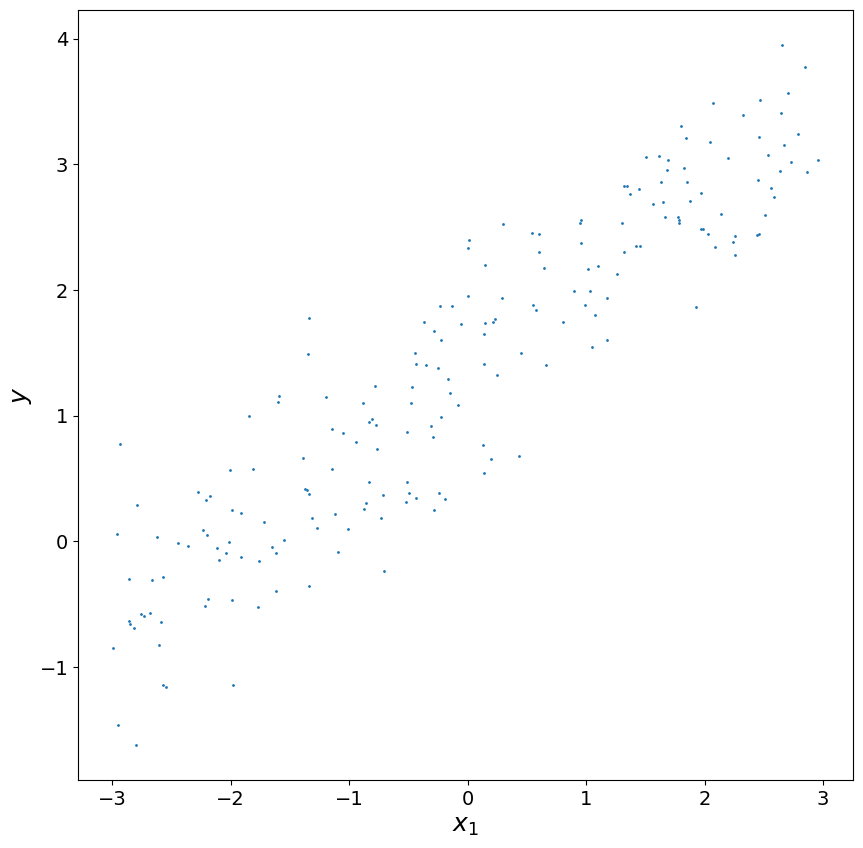

In [3]:
# Generating synthetic data
theta_true = np.array([1.4, 0.7]) # True parameter vector of bias w_0 and regression slope w_1
X = np.random.uniform(-3, 3, N) # Sample uniformly inputs for N-samples dataset
X = np.column_stack((np.ones(N), X))  # Prepend column of ones to create augmented inputs x tilde

# y = X*theta_true + noise
y = X.dot(theta_true) + np.random.normal(0, .5, N)

plt.ioff() # These lines help avoid showing the figure when I don't want to in Jupyter
fig_scatter, ax_scatter = plt.subplots(figsize=(10, 10));
plt.ion() # Re-activate "interactive" mode

ax_scatter.scatter(X[:, 1], y, s=1)
ax_scatter.set_xlabel(r"$x_1$")
ax_scatter.set_ylabel(r"$y$")

display(fig_scatter) # Display as .png

fig_scatter;

## Residual Sum Squared (RSS) Error

Our loss function $\mathcal{L}(\boldsymbol{\theta})$ in least squares linear regression is the RSS error:

\begin{equation*}
\mathcal{L}(\boldsymbol{\theta}) = \sum_{i=1}^N (\boldsymbol{\theta}^\intercal \mathbf{\tilde{x}}^{(i)} - y^{(i)})^2,
\end{equation*}

which can also be written equivalently as a matrix expression:

\begin{equation*}
\mathcal{L}(\boldsymbol{\theta}) = ||\mathbf{X}\boldsymbol{\theta} - \mathbf{y}||_2^2 = (\mathbf{X}\boldsymbol{\theta} - \mathbf{y})^\intercal (\mathbf{X}\boldsymbol{\theta} - \mathbf{y}).
\end{equation*}

The following code establishes a 2D grid of the parameter space $\boldsymbol{\theta} \in \Theta$ so that we can plot a 3D contour surface against the RSS loss values over this entire $\Theta$ space.

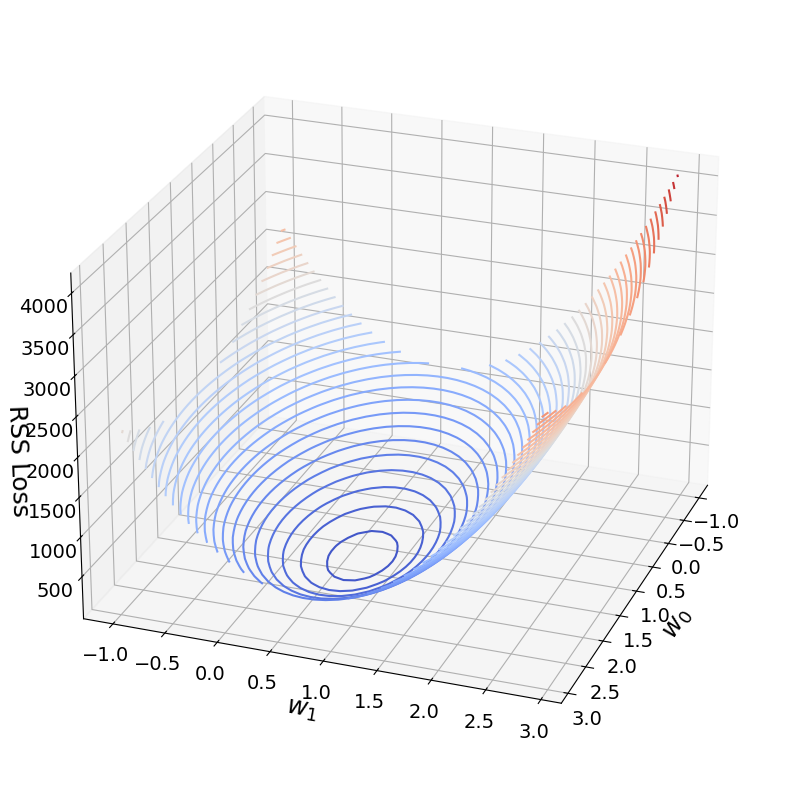

In [4]:
# Plot residual sum squared (RSS) error surface over parameter space
theta_space = np.arange(-1, 3, 0.1)
# Each theta are now coordinate matrices determmined by the theta_space
W0, W1 = np.meshgrid(theta_space, theta_space)

# Compute RSS error for each weight combination
# Split out into vector form for convenience in reshaping and feeding into the RSS surface plot
rss = np.array([sum((w0 * X[:, 0] + w1 * X[:, 1] - y) ** 2) for w0, w1 in zip(np.ravel(W0), np.ravel(W1))])
rss = rss.reshape(W0.shape)

plt.ioff() # These lines help avoid showing the figure when I don't want to in Jupyter
fig_surface = plt.figure(figsize=(10, 10))
plt.ion() # Re-activate "interactive" mode

ax_surface = fig_surface.add_subplot(111, projection="3d")
# Plot contour surface of loss function with 50 levels
cs3d = ax_surface.contour3D(W0, W1, rss, 50, cmap=cm.coolwarm)

ax_surface.set_xlabel(r"$w_0$")
ax_surface.set_ylabel(r"$w_1$")
ax_surface.set_zlabel("RSS Loss")
ax_surface.view_init(elev=25., azim=20)

display(fig_surface) # Display as .png
fig_surface;

## Gradient Computation

To find the parameter values that minimize our least squares loss function, we will require its gradient $\nabla\mathcal{L}(\boldsymbol{\theta})$ w.r.t. the parameters $\boldsymbol{\theta}$. This can be derived as:

\begin{align*}
\nabla\mathcal{L}(\boldsymbol{\theta}) & = \frac{\delta}{\delta \boldsymbol{\theta}^\intercal}\Bigg[\sum_{i=1}^N (\boldsymbol{\theta}^\intercal \mathbf{\tilde{x}}^{(i)} - y^{(i)})^2 \Bigg] = \sum_{i=1}^N \frac{\delta}{\delta \boldsymbol{\theta}^\intercal} \Big[(\boldsymbol{\theta}^\intercal \mathbf{\tilde{x}}^{(i)} - y^{(i)})^2 \Big] \\
& = \sum_{i=1}^N 2 (\boldsymbol{\theta}^\intercal \mathbf{\tilde{x}}^{(i)} - y^{(i)}) \frac{\delta (\boldsymbol{\theta}^\intercal \mathbf{\tilde{x}}^{(i)})}{\delta \boldsymbol{\theta}^\intercal} = \sum_{i=1}^N (\boldsymbol{\theta}^\intercal \mathbf{\tilde{x}}^{(i)} - y^{(i)})\mathbf{\tilde{x}}^{(i)},
\end{align*}

where the constant 2 is negligible and thus ignored in the last step, as it will not affect the optimal solution.

The gradient can also be written in matrix form:

\begin{equation*}
\nabla\mathcal{L}(\boldsymbol{\theta}) = \mathbf{X}^\intercal(\mathbf{X}\boldsymbol{\theta} - y) = \mathbf{X}^\intercal\mathbf{X}\boldsymbol{\theta} - \mathbf{X}^\intercal \mathbf{y}.
\end{equation*}

And if we are instead interested in the Mean Squared Error (MSE), we scale the gradient by $\frac{1}{N}$, which again will not affect our optimization process but provides us with an intuition on the average prediction error from actual labels.

In [5]:
# Mean Squared Error (MSE) loss with gradient for optimization:
def lin_reg_loss(theta, X, y):
    # Linear regression model X * theta
    predictions = X.dot(theta)
    # Residual error (X * theta) - y
    error = predictions - y
    # Loss function is MSE
    loss_f = np.mean(error**2)
    # Partial derivative for GD, X^T * ((X * theta) - y)
    gradient = (1 / N) * X.T.dot(error)
    
    return loss_f, gradient

## Analytical Solution

For a strictly convex function ("bowl" shaped, like the above surface plot), we have a unique global minimum. Assuming that the $\mathbf{X}^\intercal\mathbf{X}$ matrix (also known as the [Gram matrix](https://en.wikipedia.org/wiki/Gram_matrix)) is invertible, then we can rearrange the gradient and find an analytical solution $\boldsymbol{\theta}_{opt}$ to this global minimum:

\begin{equation*}
\boldsymbol{\theta}_{opt} = (\mathbf{X}^\intercal\mathbf{X})^{-1}\mathbf{X}^\intercal \mathbf{y}.
\end{equation*}

This parameter estimator $\boldsymbol{\theta}_{opt}$ is specifically known as the [Ordinary least squares estimator](https://en.wikipedia.org/wiki/Ordinary_least_squares) for a linear regression model.

<i>Aside:</i> If $\mathbf{X}^\intercal\mathbf{X}$ is singular, there exist many solutions rather than a unique one. You can get around this non-invertibility to still find an optimal solution, e.g. by computing the [pseudo-inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse). However, first note that matrix inversion can be slow for a very large matrix $\mathbf{X}$, with an algorithmic complexity of $O(Nn^2)$ that may prove impractical. Second, there will be significant loss in precision of the least squares estimate for an ill-conditioned Gram matrix due to numerical issues, where the [condition number](https://en.wikipedia.org/wiki/Condition_number) of a matrix basically measures how numerically stable that matrix is. Therefore, it is oftentimes necessary to consider an iterative optimization method for finding the solution parameter estimates.

Using the closed-form solution derived above, we can visualize its result on the above 3D contour surface and later compare against the batch GD parameter estimate.

Analytical Theta:  [1.38492126 0.69201046]
MSE:  0.24126260278934145


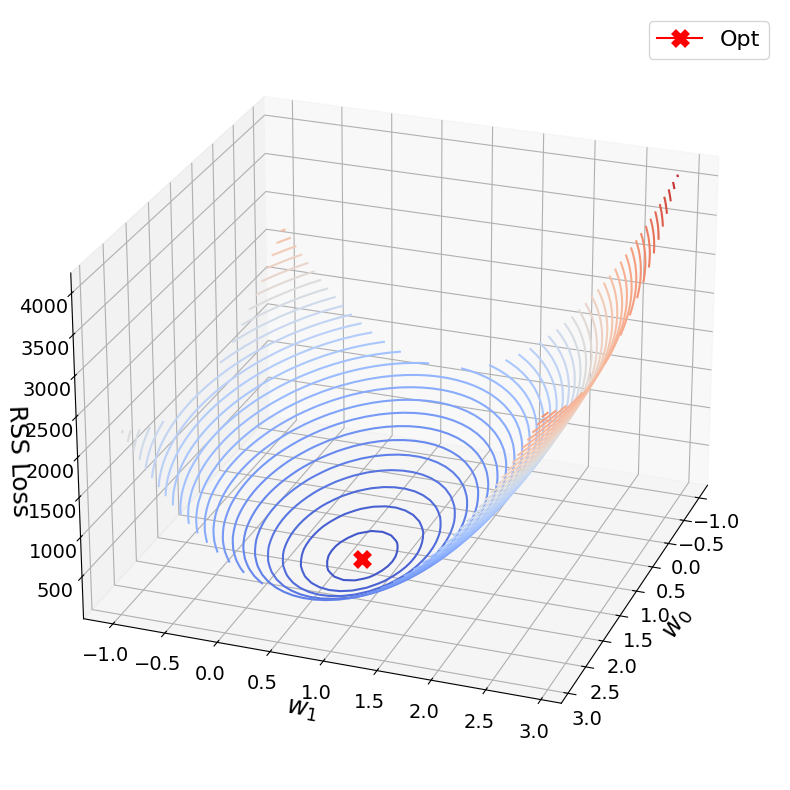

In [6]:
def analytical_solution(X, y):
    # Analytical solution is (X^T*X)^-1 * X^T * y 
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

theta_opt = analytical_solution(X, y)
rss_opt = sum((X.dot(theta_opt) - y) ** 2)
mse_opt = (1 / N) * rss_opt
print("Analytical Theta: ", theta_opt)
print("MSE: ", mse_opt)

ax_surface.plot(xs=theta_opt[0], ys=theta_opt[1], zs=rss_opt, marker='x', color='r', ms=10, mew=5, label="Opt")
ax_surface.legend()

plt.ion() # These are Jupyter only lines to avoid showing the figure when I don't want
fig_surface

## Gradient Descent

Our batch GD algorithm is as follows:

1) Initialize $\boldsymbol{\theta}^{(0)}$

2) Repeat until convergence:

\begin{align*}
\boldsymbol{\theta}^{(t+1)} & = \boldsymbol{\theta}^{(t)} - \alpha \nabla\frac{1}{2N}\mathcal{L}(\boldsymbol{\theta}^{(t)}) \\
& = \boldsymbol{\theta}^{(t)} - \alpha \Bigg(\frac{1}{N} \mathbf{X}^\intercal(\mathbf{X}\boldsymbol{\theta}^{(t)} - \mathbf{y})\Bigg).
\end{align*}

3) When $\mathbf{g}(\boldsymbol{\theta}) = \mathbf{0}$, then we have derived $\boldsymbol{\theta}_{GD}$ using batch GD

We implement this algorithm in the following cell, with $\boldsymbol{\theta}^{(0)} = \mathbf{0}$ but this could also be randomly set using the commented out line.

In [7]:
# Starting point from to search for optimal parameters
theta_init = np.array([0, 0])
#theta_init = np.random.randn(2) # Randomly sample from N(0, 1)

# Options for batch GD
opts = {}
opts['max_epoch'] = 50
opts['alpha'] = 0.1
opts['tolerance'] = 0.05


def gradient_descent(loss_func, theta_init, X, y, *args, **kwargs):
    # Batch GD.

    # Options for total sweeps over data (max_epochs), and parameters, like learning rate.

    # Default options
    max_epoch = kwargs['max_epoch'] if 'max_epoch' in kwargs else 200
    alpha = kwargs['alpha'] if 'alpha' in kwargs else 0.1
    epsilon = kwargs['tolerance'] if 'tolerance' in kwargs else 1e-6

    theta = theta_init
    trace = {}
    trace['loss'] = []
    trace['theta'] = []

    # Main loop:
    for epoch in range(1, max_epoch + 1):
        print("epoch %d\n" % epoch)
        
        mse, gradient = loss_func(theta, X, y, *args)
        # Steepest descent update
        theta = theta - alpha * gradient

        # Storing the history of the parameters and loss values (MSE)
        trace['loss'].append(mse)
        trace['theta'].append(theta)

        # Terminating Condition is based on how close we are to minimum (gradient = 0)
        if np.linalg.norm(gradient) < epsilon:
            print("Gradient Descent has converged")
            break

    return theta, trace

theta_gd, trace = gradient_descent(lin_reg_loss, theta_init, X, y, **opts)

print("GD Theta: ", theta_gd)
print("MSE: ", trace['loss'][-1])

epoch 1

epoch 2

epoch 3

epoch 4

epoch 5

epoch 6

epoch 7

epoch 8

epoch 9

epoch 10

epoch 11

epoch 12

epoch 13

epoch 14

epoch 15

epoch 16

epoch 17

epoch 18

epoch 19

epoch 20

epoch 21

epoch 22

epoch 23

epoch 24

epoch 25

epoch 26

epoch 27

epoch 28

epoch 29

epoch 30

epoch 31

epoch 32

epoch 33

Gradient Descent has converged
GD Theta:  [1.34111947 0.69054331]
MSE:  0.24362775430829797


Convert our trace of parameter and loss function values into NumPy "history" arrays:

In [8]:
theta_hist = np.asarray(trace['theta'])
mse_hist = np.array(trace['loss'])

Plot a trajectory of the parameter updates in terms of their RSS values:

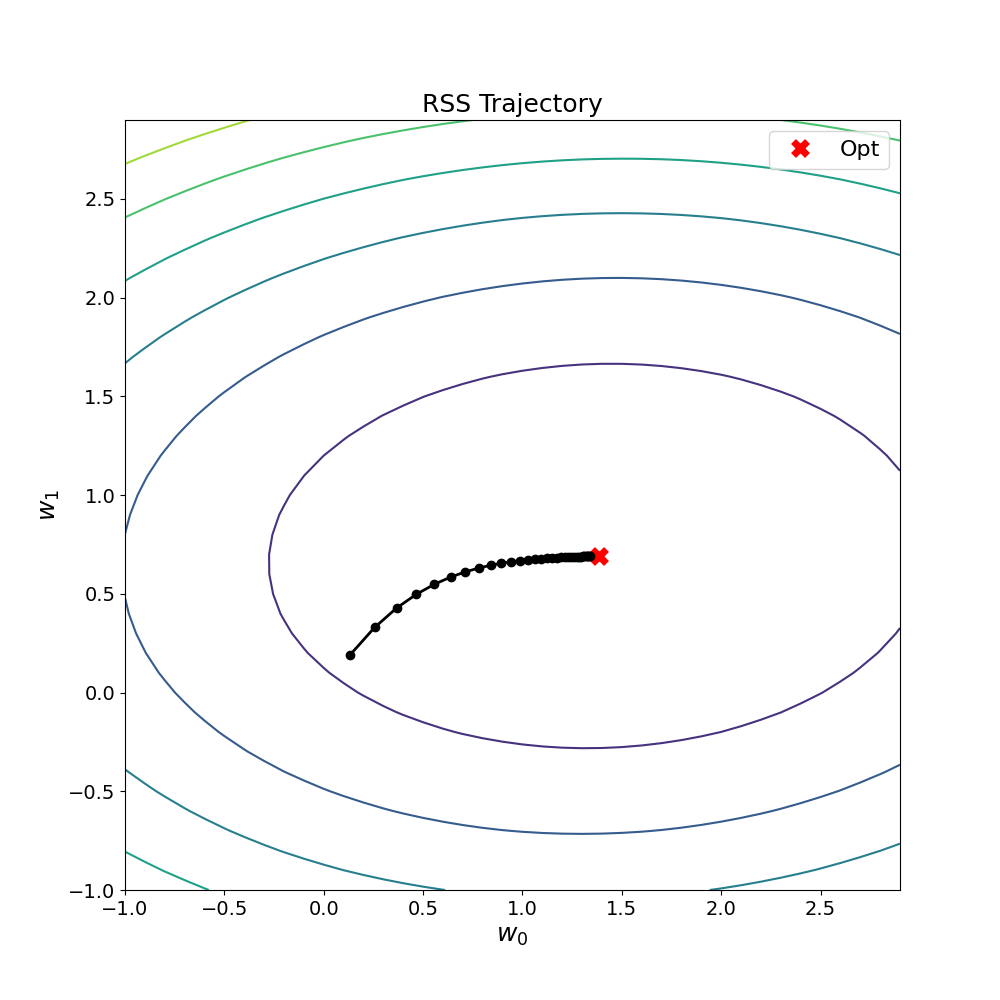

In [9]:
# Parameter trajectory as a contour plot
fig, ax_rss = plt.subplots(figsize=(10, 10))
ax_rss.set_title("RSS Trajectory")
cs = plt.contour(W0, W1, rss)
plt.plot(theta_opt[0], theta_opt[1], 'x', color='r', ms=10, mew=5, label="Opt")
plt.plot(theta_hist[:, 0], theta_hist[:, 1], 'ko-', lw=2)
plt.xlabel(r"$w_0$")
plt.ylabel(r"$w_1$")
ax_rss.legend()
plt.show()

Plot the MSE progression over training iterations (epochs), with the horizontal line showing the analytical solution:

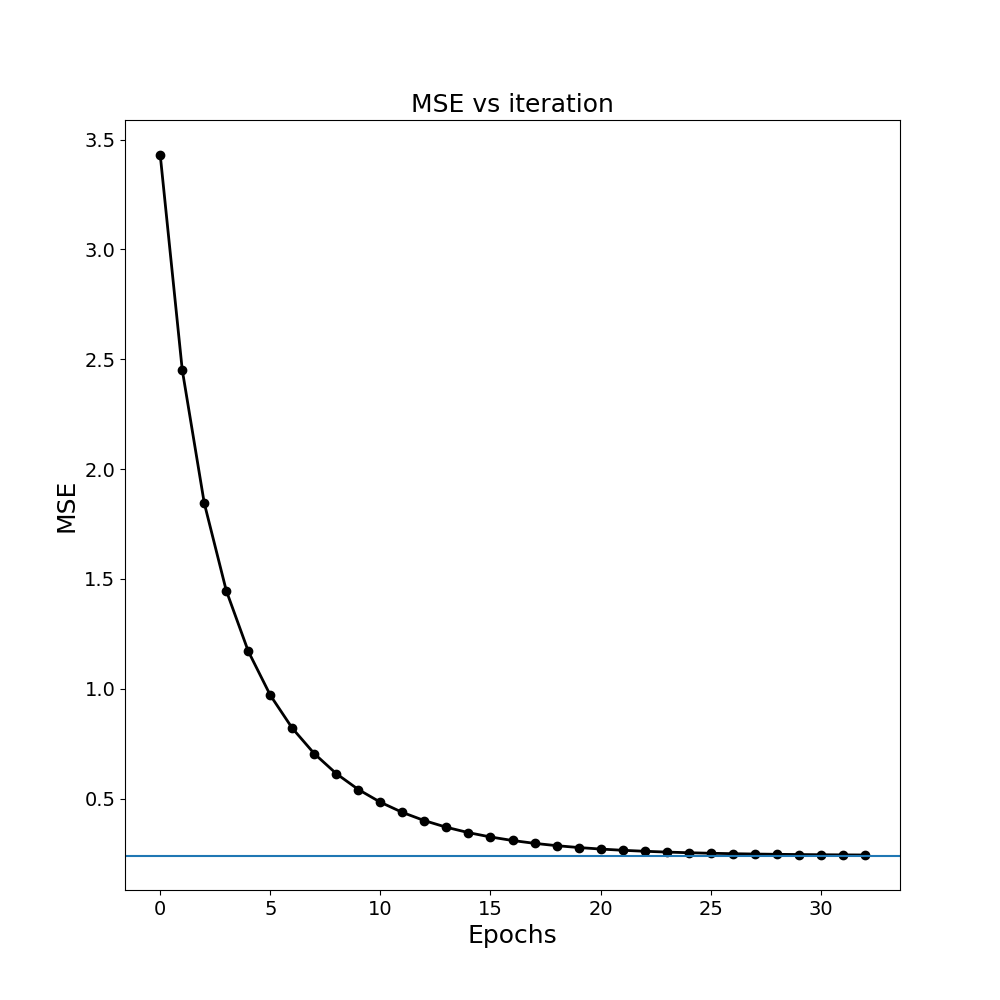

In [10]:
# Loss values over the parameter path compared to the optimal loss
fig_mse, ax_loss_iter = plt.subplots(figsize=(10, 10))
ax_loss_iter.set_title("MSE vs iteration")
plt.plot(mse_hist, 'ko-', lw=2)
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.axhline(mse_opt)
plt.draw()

Similar to the 2D contour parameter trajectory, illustrate this path as a 3D surface:

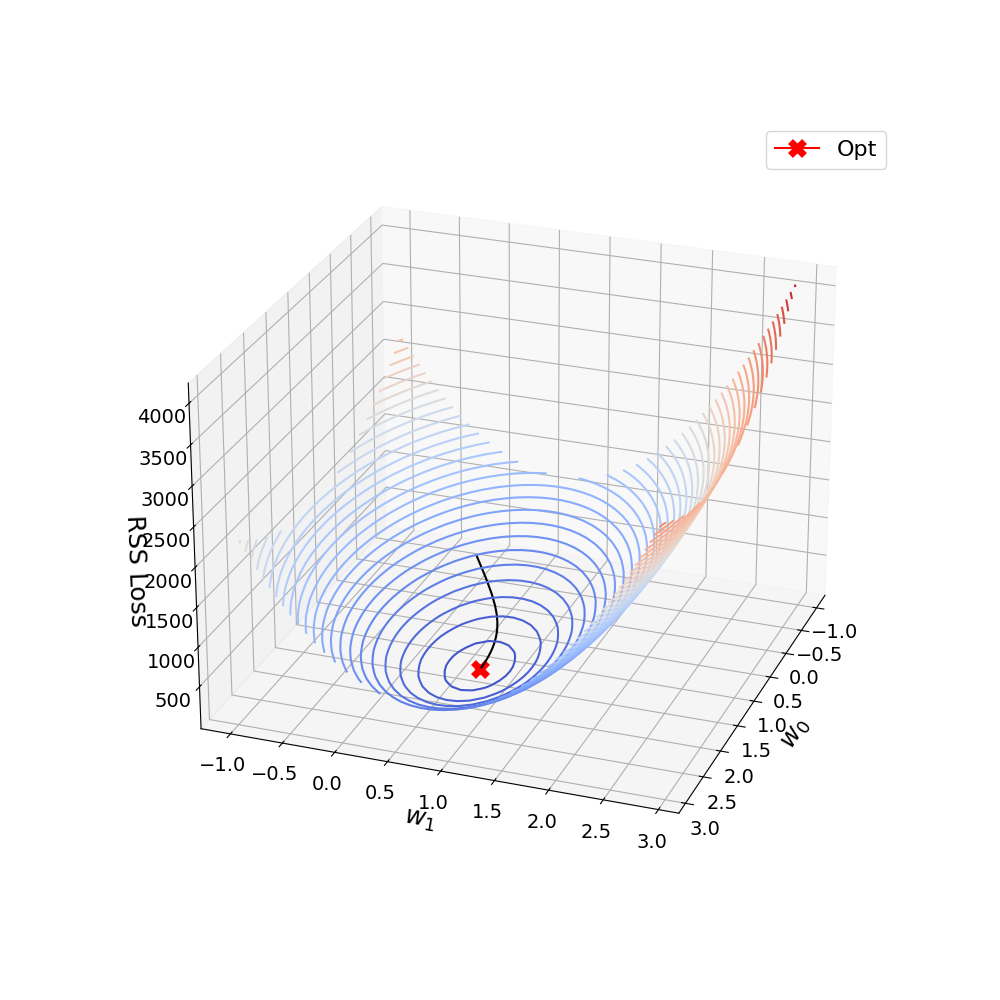

In [11]:
# 3D plot along loss function surface
ax_surface.plot(xs=theta_hist[:, 0], ys=theta_hist[:, 1], zs=N*mse_hist, c='k')

fig_surface.show()
fig_surface;

Finally plot our regression line using our $\boldsymbol{\theta}_{GD}$ estimator:

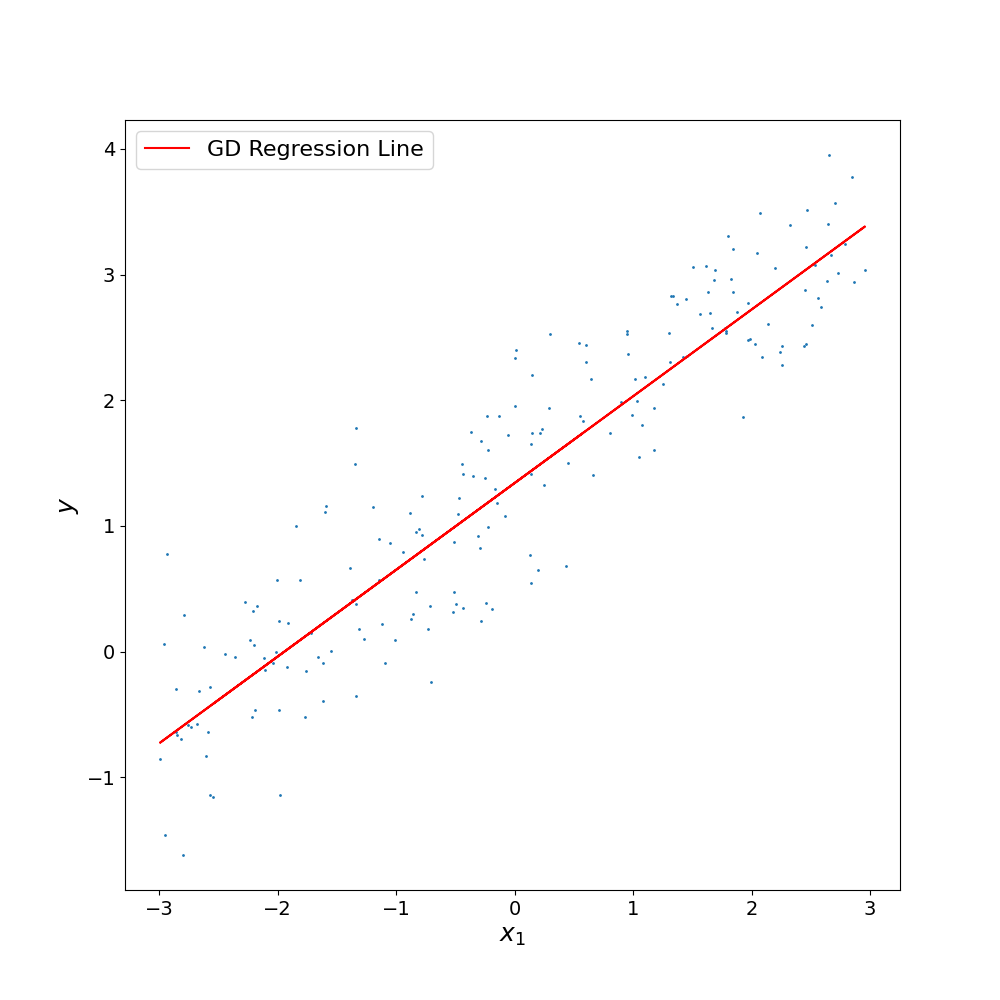

In [12]:
# Predictions with our GD trained theta
learned_predictions = X.dot(theta_gd)

# Plot the learned regression line on our original scatter plot
ax_scatter.plot(X[:,1], learned_predictions, color='red', label="GD Regression Line")
ax_scatter.legend()

fig_scatter.show()
fig_scatter;

## References

Code adapted from <i>"lms_demo.ipynb"</i> at:

@book{pml1Book,<br>
&emsp; author = "Kevin P. Murphy",<br>
&emsp; title = "Probabilistic Machine Learning: An introduction",<br>
&emsp; publisher = "MIT Press",<br>
&emsp; year = 2022,<br>
&emsp; url = "probml.ai"<br>
}